In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor
import lightgbm 
from sklearn.datasets import make_friedman2, make_friedman1, make_regression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import lightgbm
from sklearn.metrics import mean_squared_error
import seaborn as sns; sns.set()
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

### Custom metric

Customizing the validation loss in LightGBM requires defining a function that takes in the same two arrays, but returns three values: a string with name of metric to print, the loss itself, and a boolean about whether higher is better.

In [10]:
def custom_asymmetric_eval(y_true, y_pred):
    residual = (y_true - y_pred).astype("float")
    loss = np.where(residual < 0, (residual**2)*10.0, residual**2) 
    return "custom_asymmetric_eval", np.mean(loss), False

### Custom objective(loss) function
Customizing the training loss in LightGBM requires defining a function that takes in two arrays, the targets and their predictions. In turn, the function should return two arrays of the gradient and hessian of each observation.

In [11]:
def custom_asymmetric_objective(y_true, y_pred):
    residual = (y_true - y_pred).astype("float")
    grad = np.where(residual<0, -2*10.0*residual, -2*residual)
    hess = np.where(residual<0, 2*10.0, 2.0)
    return grad, hess

### Simulating Friendman dataset
About the dataset

Inputs X are independent features uniformly distributed on the interval [0, 1]. The output y is created according to the formula:
y(X) = 10 * sin(pi * X[:, 0] * X[:, 1]) + 20 * (X[:, 2] - 0.5) ** 2 + 10 * X[:, 3] + 5 * X[:, 4] + noise * N(0, 1).

Out of the n_features features, only 5 are actually used to compute y. The remaining features are independent of y.


In [4]:
# simulating 10,000 data points with 2 useless and 5 uniformly distributed features

X, y = make_friedman1(n_samples=10000, n_features=7, noise=0.0, random_state=11)

In [5]:
# train-validation split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.20, random_state=42)

In [6]:
# test set for generalization of scores
X_test, y_test = make_friedman1(n_samples=5000, n_features=7, noise=0.0, random_state=21)

In [7]:
### Plotting helper functions

def plot_residual_distribution(model):
    """
    Density plot of residuals (y_true - y_pred) for testation set for given model 
    """
    ax = sns.distplot(y_test - model.predict(X_test), hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3}, axlabel="Residual")
    title = ax.set_title('Kernel density of residuals', size=15)

def plot_scatter_pred_actual(model):
    """
    Scatter plot of predictions from given model vs true target variable from testation set
    """
    ax = sns.scatterplot(x=model.predict(X_test), y = y_test)
    ax.set_xlabel('Predictions')
    ax.set_ylabel('Actuals')
    title = ax.set_title('Actual vs Prediction scatter plot', size=15)

In [8]:
# make new model on new value
# 'regression' is actually also the default objective for LGBMRegressor

gbm2 = lightgbm.LGBMRegressor(objective='regression',
                              random_state=33,
                              early_stopping_rounds = 10,
                              n_estimators=10000
                             )

gbm2.fit(
    X_train,
    y_train,
    eval_set=[(X_valid, y_valid)],
    eval_metric='l2',  # also the default
    verbose=False,
)

/root/anaconda3/envs/mypy37/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              early_stopping_rounds=10, importance_type='split',
              learning_rate=0.1, max_depth=-1, min_child_samples=20,
              min_child_weight=0.001, min_split_gain=0.0, n_estimators=10000,
              n_jobs=-1, num_leaves=31, objective='regression', random_state=33,
              reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0)

#### LightGBM_early_boosting custom eval_metric + objective

In [12]:
# make new model on new value
gbm6 = lightgbm.LGBMRegressor(random_state=33,
                              early_stopping_rounds = 10,
                              n_estimators=10000
                             )

gbm6.set_params(**{'objective': custom_asymmetric_objective}, metrics = ["mse", 'mae'])

gbm6.fit(
    X_train,
    y_train,
    eval_set=[(X_valid, y_valid)],
    eval_metric=custom_asymmetric_eval,
    verbose=False,
)

/root/anaconda3/envs/mypy37/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              early_stopping_rounds=10, importance_type='split',
              learning_rate=0.1, max_depth=-1, metrics=['mse', 'mae'],
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=10000, n_jobs=-1, num_leaves=31,
              objective=<function custom_asymmetric_objective at 0x7f14fc18f440>,
              random_state=33, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

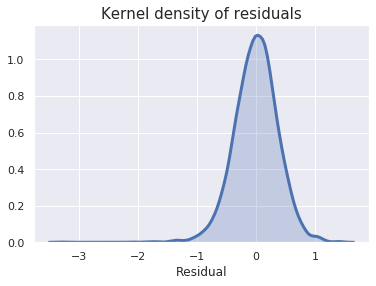

In [15]:
# distribution of residual
plot_residual_distribution(gbm2)

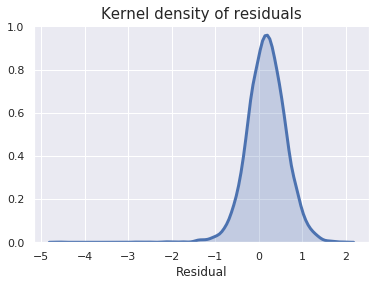

In [16]:
# distribution of residual
plot_residual_distribution(gbm6)

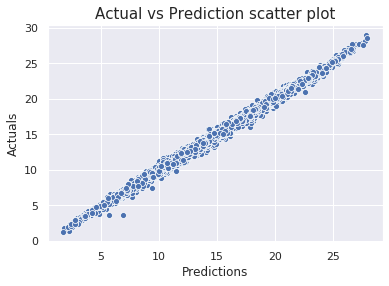

In [17]:
plot_scatter_pred_actual(gbm2)

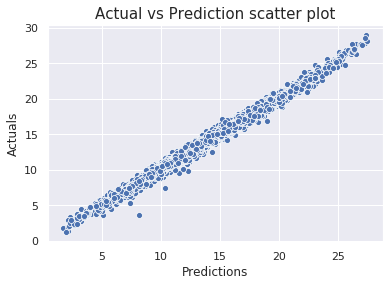

In [18]:
plot_scatter_pred_actual(gbm6)